In [62]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau, kruskal
import matplotlib.pyplot as plt

# Comparison of Green Spaces - Air Quality Index

The air quality index is uniform across all coordinates. Therefore, comparison and statistical testing in this section is done for every coordinate

In [63]:
def process_greenspace_aqi(ndvi_path, aqi_path):
    """
    Function to process and merge NDVI and AQI data per greenspace

    :param ndvi_path:
    :param aqi_path:
    :return:
    """
    ndvi_data = pd.read_csv(ndvi_path)
    aqi_data = pd.read_csv(aqi_path)

    merged_data = pd.merge(ndvi_data, aqi_data, left_index=True, right_index=True, how="inner")

    return merged_data

In [64]:
# Define file aqi and ndvi file paths for greenspaces
greenspace_files_aqi = {
    "Vondelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Vondelpark/Vondel_AirQualityIndex/Vondel_AirQualityIndex_csv.csv",
    },
    "Westerpark": {
        "NDVI": "Datasets/Sentinel-2/Wester_NDVI/Wester_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Westerpark/Wester_AirQualityIndex/Wester_AirQualityIndex_csv.csv",
    },
    "Amstelpark": {
        "NDVI": "Datasets/Sentinel-2/Amstel_NDVI/Amstel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Amstelpark/Amstel_AirQualityIndex/Amstel_AirQualityIndex_csv.csv",
    },
    "Rembrandtpark": {
        "NDVI": "Datasets/Sentinel-2/Rembrandt_NDVI/Rembrandt_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Rembrandtpark/Rembrandt_AirQualityIndex/Rembrandt_AirQualityIndex_csv.csv",
    },
}

In [65]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces = {}
for park, paths in greenspace_files_aqi.items():
    greenspaces[park] = process_greenspace_aqi(paths["NDVI"], paths["AQI"])

In [66]:
def clean_merged_data(merged_csv):
    """
    Function to clean merged data and apply a cumulative cut-off range, preparing it for statistical testing

    :param merged_csv:
    :return:
    """

    # Drop missing values
    cleaned_csv = merged_csv.copy().dropna()

    # Combine coordinate and date columns
    cleaned_csv.loc[:, 'Date'] = cleaned_csv['Date_x'].combine_first(cleaned_csv['Date_y'])
    cleaned_csv.loc[:, 'Coordinates'] = cleaned_csv['Coordinates_x'].combine_first(cleaned_csv['Coordinates_y'])

    # Drop redundant columns
    cleaned_csv.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    cleaned_csv.rename(columns={'Value_x': 'NDVI', 'Value_y': 'AQI'}, inplace=True)

    # Apply cumulative cut on NDVI
    ndvi_data = cleaned_csv['NDVI'].copy()
    sorted_ndvi_data = ndvi_data.sort_values().reset_index(drop=True)

    # Calculate cumulative percentages
    cumulative_percentage = sorted_ndvi_data.rank(pct=True)

    # Define cut-off range
    lower_cut = 0.02
    upper_cut = 0.98

    # Filter NDVI values within range
    filtered_NDVI_data = sorted_ndvi_data[
        (cumulative_percentage >= lower_cut) &
        (cumulative_percentage <= upper_cut)
    ]

    # Set lower and upper values for NDVI
    lower_cut_value = filtered_NDVI_data.min()
    upper_cut_value = filtered_NDVI_data.max()

    # Keep NDVI rows where NDVI value is within range
    cleaned_csv_final = cleaned_csv[
        (cleaned_csv['NDVI'] >= lower_cut_value) &
        (cleaned_csv['NDVI'] <= upper_cut_value)
    ]

    return cleaned_csv_final

# Apply the cleaning function to all greenspaces
greenspaces_cleaned = {park: clean_merged_data(data) for park, data in greenspaces.items()}

In [67]:
# Store correlation metrics for easy access
correlation_results_aqi = {}

for park, data in greenspaces_cleaned.items():
    pearson_corr, _ = pearsonr(data["NDVI"], data["AQI"])
    spearman_corr, _ = spearmanr(data["NDVI"], data["AQI"])
    kendall_corr, _ = kendalltau(data["NDVI"], data["AQI"])

    correlation_results_aqi[park] = {
        "Pearson's Correlation": pearson_corr,
        "Spearman's Correlation": spearman_corr,
        "Kendall's Tau Correlation": kendall_corr,
    }

    print(f"{park} => Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}, Kendall: {kendall_corr:.2f}")

Vondelpark => Pearson: -0.04, Spearman: -0.17, Kendall: -0.11
Westerpark => Pearson: 0.02, Spearman: -0.10, Kendall: -0.06
Amstelpark => Pearson: 0.07, Spearman: -0.07, Kendall: -0.03
Rembrandtpark => Pearson: 0.03, Spearman: -0.14, Kendall: -0.10


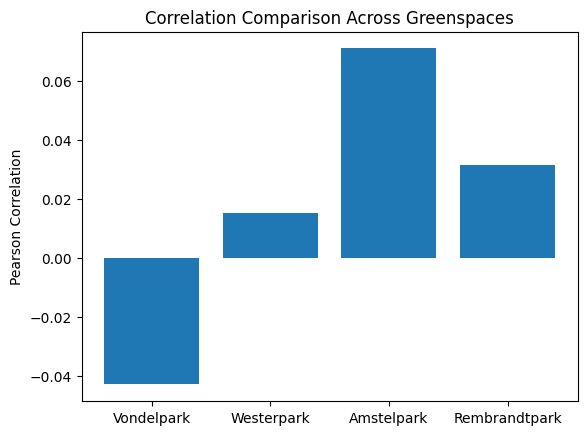

In [68]:
# Visualizing correlation comparison across greenspaces
correlation_values_aqi = {park: values["Pearson's Correlation"] for park, values in correlation_results_aqi.items()}
plt.bar(correlation_values_aqi.keys(), correlation_values_aqi.values())
plt.ylabel('Pearson Correlation')
plt.title('Correlation Comparison Across Greenspaces')
plt.show()

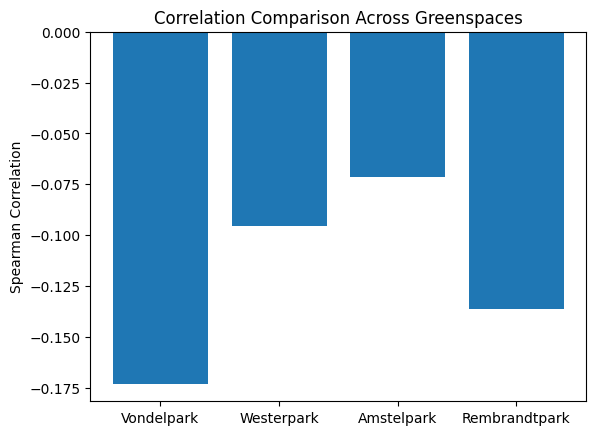

In [69]:
# Visualizing correlation comparison across greenspaces
correlation_values_aqi = {park: values["Spearman's Correlation"] for park, values in correlation_results_aqi.items()}
plt.bar(correlation_values_aqi.keys(), correlation_values_aqi.values())
plt.ylabel('Spearman Correlation')
plt.title('Correlation Comparison Across Greenspaces')
plt.show()

In [70]:
# Perform Kruskal-Wallis test to compare correlations statistically
all_correlations_aqi = [data[['NDVI', 'AQI']].corr().iloc[0, 1] for data in greenspaces_cleaned.values()]
_, p_value = kruskal(*all_correlations_aqi)

print(f"Kruskal-Wallis Test p-value: {p_value:.4f}")

Kruskal-Wallis Test p-value: 0.3916


In [71]:
print("Mean correlation:", np.mean(all_correlations_aqi))
print("Standard deviation:", np.std(all_correlations_aqi))

Mean correlation: 0.01869319133791398
Standard deviation: 0.04090666616681443


Interpretation of the Results:

Since the p-value for the Kruskal-Wallis test is greater than the conventional significance threshold (0.05), we fail to reject the null hypothesis.
This means that there is no statistically significant difference in the correlation values of NDVI and AQI across the greenspaces analyzed, as the correlation strength does not vary significantly between the parks. This could be due to the relative closeness of the parks themselves, which when coupled with the low resolution of the Sentinel-5P satellite makes it hard to compare these parks effectively.

Regarding the correlations themselves, the values are relatively low across all greenspaces, as can be seen from the low mean correlation. There seems to be a slight negative correlation between NDVI and AQI, which indicates that a lower AQI will result in a higher NDVI. With more data (i.e., looking at more years and more parks) this relationship might be more pronounced.


# Comparison of Greenspaces - Soil Moisture

Sentinel-1 (satellite used for Soil Moisture data) has a lower resolution than Sentinel-2 (satellite used for NDVI date). Therefore, values for soil moisture where matched with NDVI values according to the nearest coordinate. Important to note that there are some missing months when downloading the dataset from OpenEO, namely the 01, 09, 10, 11 and 12 months.

In [72]:
# Define file soil moisture and ndvi file paths for greenspaces
greenspace_files_soil_moisture = {
    "Vondelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Vondelpark/Vondel_SoilMoisture_csv.csv",
    },
    "Westerpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Westerpark/Wester_SoilMoisture_csv.csv",
    },
    "Amstelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Amstelpark/Amstel_SoilMoisture_csv.csv",
    },
    "Rembrandtpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Rembrandtpark/Rembrandt_SoilMoisture_csv.csv",
    },
}

In [73]:
def process_soil_moisture_data(ndvi_path, soil_moisture_path):
    """
    Function to process and merge soil moisture and NDVI data per greenspace

    :param ndvi_path:
    :param soil_moisture_path:
    :return:
    """
    ndvi_data = pd.read_csv(ndvi_path)
    soil_moisture_data = pd.read_csv(soil_moisture_path)

    merged_data = pd.merge(ndvi_data, soil_moisture_data, left_index=True, right_index=True, how="inner")

    return merged_data

In [74]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces_data_soil_moisture = {}
for park, paths in greenspace_files_soil_moisture.items():
    greenspaces_data_soil_moisture[park] = process_soil_moisture_data(paths["NDVI"], paths["soil_moisture"])

In [75]:
# Function to load and clean each greenspace dataset
def clean_merged_data(merged_data):
    """
    Function to clean merged data and apply a cumulative cut-off range, preparing it for statistical testing

    :param merged_csv:
    :return:
    """

    # Drop missing values
    df_cleaned = merged_data.copy().dropna()

    # Combine coordinate and date columns
    df_cleaned.loc[:, 'Date'] = df_cleaned['Date_x'].combine_first(df_cleaned['Date_y'])
    df_cleaned.loc[:, 'Coordinates'] = df_cleaned['Coordinates_x'].combine_first(df_cleaned['Coordinates_y'])

    # Drop redundant columns
    df_cleaned.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    df_cleaned.rename(columns={'Value_x': 'NDVI', 'Value_y': 'Soil_Moisture'}, inplace=True)

    # Apply cumulative filtering to remove outliers
    ndvi_data = df_cleaned['NDVI'].copy()
    sorted_ndvi_data = ndvi_data.sort_values().reset_index(drop=True)

    # Calculate cumulative percentages
    cumulative_percentage = sorted_ndvi_data.rank(pct=True)

    # Define cut-off range
    lower_cut = 0.02
    upper_cut = 0.98

    # Filter NDVI values within range
    filtered_NDVI_data = sorted_ndvi_data[
        (cumulative_percentage >= lower_cut) &
        (cumulative_percentage <= upper_cut)
        ]

    lower_cut_value = filtered_NDVI_data.min()
    upper_cut_value = filtered_NDVI_data.max()

    df_final = df_cleaned[
        (df_cleaned['NDVI'] >= lower_cut_value) &
        (df_cleaned['NDVI'] <= upper_cut_value)
        ]

    return df_final

# Apply cleaning function
greenspaces_cleaned_soil_moisture = {park: clean_merged_data(data) for park, data in greenspaces_data_soil_moisture.items()}

In [76]:
correlation_results_soil_moisture = {}

for park, data in greenspaces_cleaned_soil_moisture.items():
    ndvi_values = data['NDVI']
    soil_moisture_values = data['Soil_Moisture']

    pearson_corr, _ = pearsonr(ndvi_values, soil_moisture_values)
    spearman_corr, _ = spearmanr(ndvi_values, soil_moisture_values)
    kendall_corr, _ = kendalltau(ndvi_values, soil_moisture_values)

    correlation_results_soil_moisture[park] = {
        "Pearson": pearson_corr,
        "Spearman": spearman_corr,
        "Kendall": kendall_corr
    }

    print(f"{park} - Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}, Kendall: {kendall_corr:.2f}")

Vondelpark - Pearson: -0.10, Spearman: -0.34, Kendall: -0.23
Westerpark - Pearson: 0.00, Spearman: 0.03, Kendall: 0.02
Amstelpark - Pearson: -0.06, Spearman: -0.08, Kendall: -0.05
Rembrandtpark - Pearson: -0.00, Spearman: 0.08, Kendall: 0.05


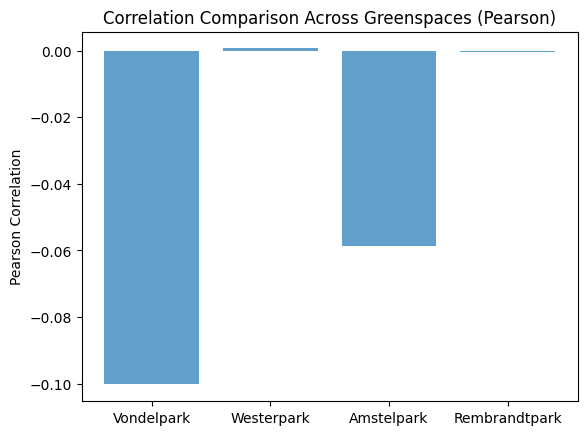

In [77]:
# Plot Pearson Correlations
parks = list(correlation_results_soil_moisture.keys())
pearson_values = [correlation_results_soil_moisture[park]["Pearson"] for park in parks]

plt.bar(parks, pearson_values, alpha=0.7)
plt.ylabel("Pearson Correlation")
plt.title("Correlation Comparison Across Greenspaces (Pearson)")
plt.show()

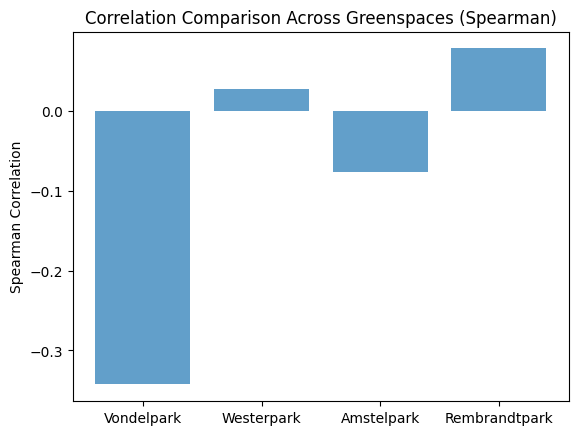

In [78]:
# Plot Spearman Correlations
spearman_values = [correlation_results_soil_moisture[park]["Spearman"] for park in parks]

plt.bar(parks, spearman_values, alpha=0.7)
plt.ylabel("Spearman Correlation")
plt.title("Correlation Comparison Across Greenspaces (Spearman)")
plt.show()

In [79]:
# Prepare the correlation values for statistical testing
all_correlations = [data[['NDVI', 'Soil_Moisture']].corr().iloc[0, 1] for data in greenspaces_cleaned_soil_moisture.values()]

# Kruskal-Wallis test
_, p_value = kruskal(*all_correlations)

print(f"Kruskal-Wallis Test p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant differences exist between greenspaces.")
else:
    print("No significant differences between greenspaces.")

Kruskal-Wallis Test p-value: 0.3916
No significant differences between greenspaces.


In [80]:
# Calculate mean and standard deviation of Pearson correlations
pearson_mean = np.mean(pearson_values)
pearson_std = np.std(pearson_values)

print(f"Mean Pearson Correlation: {pearson_mean:.4f}")
print(f"Standard Deviation: {pearson_std:.4f}")

Mean Pearson Correlation: -0.0397
Standard Deviation: 0.0424


Interpretation of the Results:

There are no statistically significant differences in the correlation values of soil moisture and NDVI across the four greenspaces. This suggests that the relationship between soil moisture and NDVI remains relatively consistent across all locations.

Vondelpark shows much stronger negative correlation when compared to the other greenspaces. This makes sense as the bounding box for Vondelpark involved urban areas, and thus is evident that soil moisture is an important component for vegetation health. The negative mean correlation suggests a general inverse relationship between soil moisture and NDVI across the greenspaces. The standard deviation indicates moderate variability in the correlation across different locations, implying that the strength of the relationship varies but not drastically. The visualizations confirm that while Amstelpark has a weak positive correlation, the other greenspaces show a tendency for NDVI to decrease as soil moisture increases.



# Comparison of Green Spaces - Land Surface Temperature

Sentinel-3 (satellite used for Land Temperature data) has a lower resolution than Sentinel-2 (satellite used for NDVI date). Therefore, values for soil moisture where matched with NDVI values according to the nearest coordinate. Important to note that some months are missing from the data, namely 08, 09 and 10

In [81]:
# Define file land surface temperature and ndvi file paths for greenspaces
greenspace_files_land_temp = {
    "Vondelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Vondelpark/Vondel_LandTemp_csv.csv",
    },
    "Westerpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Westerpark/Wester_LandTemp_csv.csv",
    },
    "Amstelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Amstelpark/Amstel_LandTemp_csv.csv",
    },
    "Rembrandtpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Rembrandtpark/Rembrandt_LandTemp_csv.csv",
    },
}

In [82]:
def process_land_temp_data(ndvi_path, land_temp_path):
    """
    Function to process and merge land temperature and NDVI data per greenspace

    :param ndvi_path:
    :param land_temp_path:
    :return:
    """
    ndvi_data = pd.read_csv(ndvi_path)
    soil_moisture_data = pd.read_csv(land_temp_path)

    merged_data = pd.merge(ndvi_data, soil_moisture_data, left_index=True, right_index=True, how="inner")

    return merged_data

In [83]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces_data_land_temperature = {}
for park, paths in greenspace_files_land_temp.items():
    greenspaces_data_land_temperature[park] = process_land_temp_data(paths["NDVI"], paths["land_temp"])

In [84]:
# Function to load and clean each greenspace dataset
def clean_merged_data(merged_data):
    """
    Function to clean merged data and apply a cumulative cut-off range, preparing it for statistical testing

    :param merged_csv:
    :return:
    """

    # Drop missing values
    df_cleaned = merged_data.copy().dropna()

    # Combine coordinate and date columns
    df_cleaned.loc[:, 'Date'] = df_cleaned['Date_x'].combine_first(df_cleaned['Date_y'])
    df_cleaned.loc[:, 'Coordinates'] = df_cleaned['Coordinates_x'].combine_first(df_cleaned['Coordinates_y'])

    # Drop redundant columns
    df_cleaned.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    df_cleaned.rename(columns={'Value_x': 'NDVI', 'Value_y': 'Land_Temp'}, inplace=True)

    # Apply cumulative filtering to remove outliers
    ndvi_data = df_cleaned['NDVI'].copy()
    sorted_ndvi_data = ndvi_data.sort_values().reset_index(drop=True)

    # Calculate cumulative percentages
    cumulative_percentage = sorted_ndvi_data.rank(pct=True)

    # Define cut-off range
    lower_cut = 0.02
    upper_cut = 0.98

    # Filter NDVI values within range
    filtered_NDVI_data = sorted_ndvi_data[
        (cumulative_percentage >= lower_cut) &
        (cumulative_percentage <= upper_cut)
        ]

    lower_cut_value = filtered_NDVI_data.min()
    upper_cut_value = filtered_NDVI_data.max()

    df_final = df_cleaned[
        (df_cleaned['NDVI'] >= lower_cut_value) &
        (df_cleaned['NDVI'] <= upper_cut_value)
        ]

    return df_final

# Apply cleaning function
greenspaces_cleaned_land_temperature = {park: clean_merged_data(data) for park, data in greenspaces_data_land_temperature.items()}

In [85]:
correlation_results_land_temp = {}

for park, data in greenspaces_cleaned_land_temperature.items():
    ndvi_values = data['NDVI']
    land_temp_values = data['Land_Temp']

    pearson_corr, _ = pearsonr(ndvi_values, land_temp_values)
    spearman_corr, _ = spearmanr(ndvi_values, land_temp_values)
    kendall_corr, _ = kendalltau(ndvi_values, land_temp_values)

    correlation_results_land_temp[park] = {
        "Pearson": pearson_corr,
        "Spearman": spearman_corr,
        "Kendall": kendall_corr
    }

    print(f"{park} - Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}, Kendall: {kendall_corr:.2f}")

Vondelpark - Pearson: 0.62, Spearman: 0.66, Kendall: 0.47
Westerpark - Pearson: -0.26, Spearman: -0.32, Kendall: -0.19
Amstelpark - Pearson: 0.15, Spearman: 0.25, Kendall: 0.18
Rembrandtpark - Pearson: -0.46, Spearman: -0.50, Kendall: -0.32


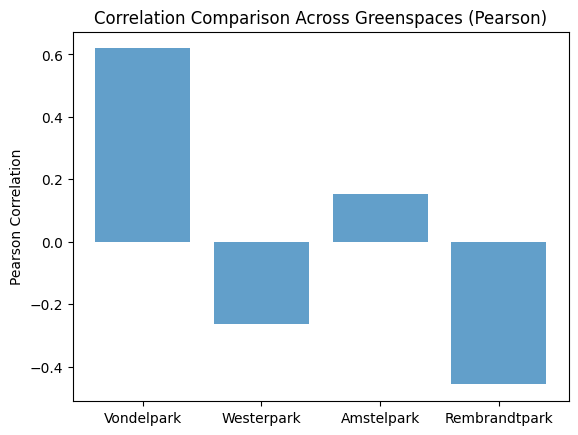

In [86]:
# Plot Pearson Correlations
parks = list(correlation_results_land_temp.keys())
pearson_values = [correlation_results_land_temp[park]["Pearson"] for park in parks]

plt.bar(parks, pearson_values, alpha=0.7)
plt.ylabel("Pearson Correlation")
plt.title("Correlation Comparison Across Greenspaces (Pearson)")
plt.show()

In [87]:
# Prepare the correlation values for statistical testing
all_correlations = [data[['NDVI', 'Land_Temp']].corr().iloc[0, 1] for data in greenspaces_cleaned_land_temperature.values()]

# Kruskal-Wallis test
_, p_value = kruskal(*all_correlations)

print(f"Kruskal-Wallis Test p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant differences exist between greenspaces.")
else:
    print("No significant differences between greenspaces.")

Kruskal-Wallis Test p-value: 0.3916
No significant differences between greenspaces.


In [89]:
# Calculate mean and standard deviation of Pearson correlations
pearson_mean = np.mean(pearson_values)
pearson_std = np.std(pearson_values)

print(f"Mean Pearson Correlation: {pearson_mean:.4f}")
print(f"Standard Deviation: {pearson_std:.4f}")

Mean Pearson Correlation: 0.0124
Standard Deviation: 0.4135


Interpretation of Results:

The Kruskal-Wallis test results indicate no statistically significant differences in the correlation values of NDVI and land surface temperature across the analyzed greenspaces. This suggests that the relationship between these factors is relatively consistent across locations. The correlation values show variation, with some parks exhibiting a moderate positive relationship, while others show a negative trend. This variability could be influenced by localized environmental factors and differences in park characteristics. Expanding the dataset across different seasons and additional locations may help clarify these patterns and provide deeper insights.

The results suggest that the influence that LST has on NDVI is varies per greenspace. Factors such as vegetation type, shading effects, and microclimates could influence this correlation. LST might have a lagged effect on vegetation health, meaning short-term changes in temperature may not immediately reflect in NDVI values.  With more data (i.e., looking at more years and more parks) this relationship might be able to be investigated further. Also, important to note that the vondel park greenspace does contain some urban areas in its bounding box, and this is the one that shows the greater correlation
